In [3]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [ ]:
# !pip uninstall numba
# !pip install --upgrade numba

In [4]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

In [5]:
raw_df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
raw_df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)

In [6]:
# df = raw_df.head(1000)
df = raw_df
threshold = 1
column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) >= threshold]
print(len(column_list))

276


1    159
0    117
Name: diagnosis, dtype: int64
disease3     59
normal3      59
disease1B    39
disease2B    37
normal2B     35
disease4     24
normal4      23
Name: slide name, dtype: int64


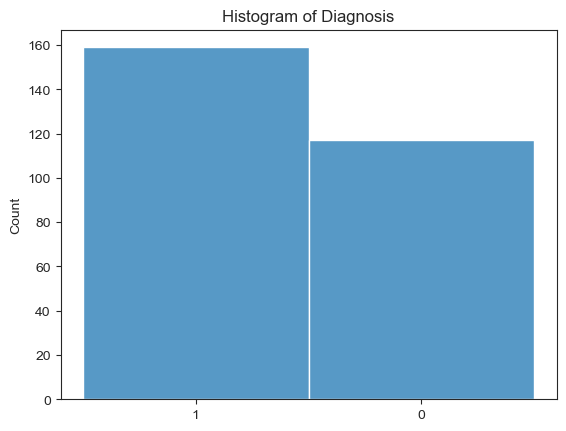

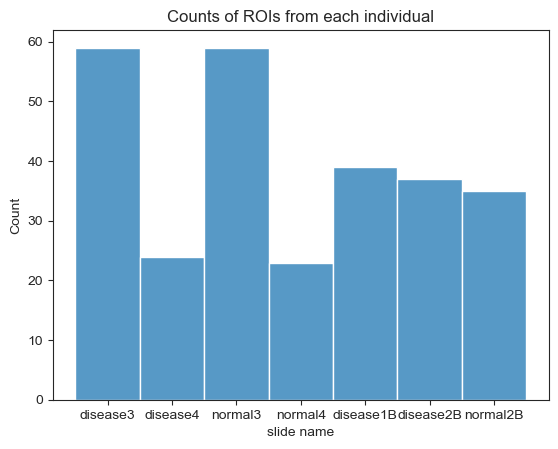

In [28]:
print(meta_df['diagnosis'].value_counts())
print(meta_df['slide name'].value_counts())
sns.histplot([str(x) for x in meta_df['diagnosis'].values])
plt.title('Histogram of Diagnosis')
plt.show()

sns.histplot(meta_df['slide name'])
plt.title('Counts of ROIs from each individual')
plt.show()

         gene  DSP-1001250007851-H-A02.dcc  DSP-1001250007851-H-A03.dcc  \
0  RTS0020877                          485                          262   
1  RTS0020878                           15                           18   
2  RTS0020879                           31                           15   
3  RTS0020880                           27                           17   
4  RTS0020881                           29                           24   

   DSP-1001250007851-H-A04.dcc  DSP-1001250007851-H-A05.dcc  \
0                          225                          312   
1                            5                           19   
2                           15                           25   
3                           24                           19   
4                           21                           17   

   DSP-1001250007851-H-A06.dcc  DSP-1001250007851-H-A07.dcc  \
0                          563                          214   
1                           26              

We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^iB_j$$
$$P\left(Y_i\right)=\text{logit}\left(Z_i\right)$$
$$B_j\sim N\left(0,\sigma\right)$$
$$\sigma=1$$

In [7]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

In [8]:

# # Option 1: normalize by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
# X = np.array([df[col]*10/sum(df[col]) for col in column_list])
# print(len(X))

# Option 2: normalize using z-score method:
X = [sp.stats.zscore(df[col]).tolist() for col in column_list]

Y = []
for col in column_list:
    Y.append(int(meta_df[meta_df['ROI']==col]['diagnosis'].values[0]))

# print(Y)
print(len(Y))
# print(X)
print(len(X))
print(len(X[0]))

276
276
18642


In [ ]:
import json
data = {'N': len(X), 'q': len(df), 'X': X, 'Y': Y}

with open("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/genes/model_norm/model_norm.data.json", "w") as f:
    json.dump(data, f)

In [9]:
model = stan.build(model_code, data={'N': len(X), 'q': len(df), 'X': X, 'Y': Y})

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 13, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

In [ ]:
fit = model.sample(num_chains=4, num_samples=1000)

In [ ]:
fit_az = arviz.from_pystan(fit)
arviz.summary(fit_az)

       lp__     alpha    beta.1   beta.2    beta.3    beta.4    beta.5  \
0 -0.527997 -0.000653 -0.024623  0.00284 -0.005888  0.004029 -0.021484   

    beta.6    beta.7    beta.8  ...    z.267    z.268    z.269    z.270  \
0 -0.00303  0.001284 -0.002414  ...  12.3863  9.62387  12.8525  9.41928   

     z.271    z.272    z.273    z.274    z.275    z.276  
0  11.6797  12.8517  6.30093  4.25333  13.3428  12.2219  

[1 rows x 18920 columns]
1


<Axes: ylabel='Count'>

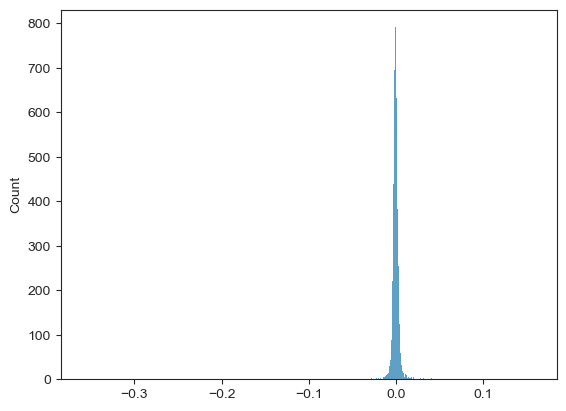

In [11]:
t_out = pd.read_csv("/Users/ethanratliff-crain/opt/anaconda3/envs/stan/bin/cmdstan/output.csv",
                    comment='#')
print(t_out.head())
print(len(t_out))
t_betas = [t_out[col][0] for col in t_out.columns if 'beta' in col]
# p_betas = [np.mean(x) for x in fit['beta']]
# sns.histplot(p_betas, label='sampled')
sns.histplot(t_betas, label='optimized')


In [ ]:
az.plot_trace(fit_simple_az, var_names=['alpha', 'beta', 'sigma']);
plt.tight_layout()

In [ ]:
# any diverging transitions?
print("Number of diverging samples: {}".format(fit['divergent__'].sum()))

In [ ]:
print(len(fit['beta']))

In [ ]:
# posterior of z
plt.figure(figsize=(4, 4))
sns.kdeplot(fit['beta'][:])
plt.xlabel(r"$\beta$")
plt.ylabel("Posterior density")
sns.despine()
plt.legend()

In [ ]:
# viz_scatter()
from sklearn.metrics import confusion_matrix
import random

correct_guesses = 0
total_guesses = 0
# add simulated data points
for i in range(10):
    idx = np.random.randint(0, 4000)
    scaled = [fit['beta'][:, idx] * x[:] for x in X]
    z = [fit['alpha'][0, idx] + sum(s) for s in scaled]
    Y_tilde = np.exp(z) / (1 + np.exp(z))
    plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
#     r = [random.random() for _ in range(len(Y_tilde))]
#     correct_guesses += len(r[r < Y_tilde])
#     total_guesses += len(r)

# print(correct_guesses / total_guesses)

plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# sns.despine()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[9.99883607e-01 9.99607634e-01 9.99989383e-01 9.99930401e-01
 9.99992989e-01 9.99996908e-01 9.99998647e-01 9.98814718e-01
 9.99365739e-01 9.99972005e-01 9.99817899e-01 9.9

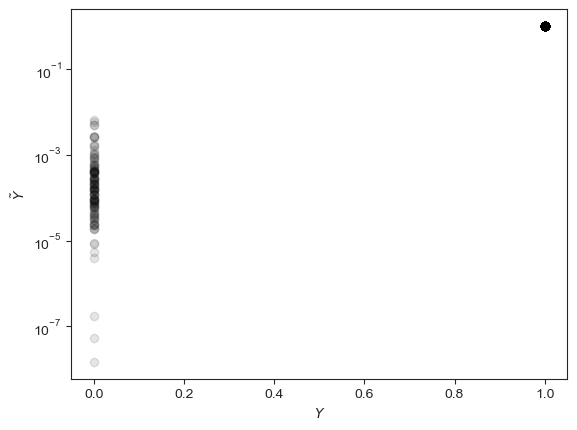

In [18]:
correct_guesses = 0
total_guesses = 0
# add simulated data points

scaled = [np.array(t_betas) * x[:] for x in X]
z = [t_out['alpha'][0] + sum(s) for s in scaled]
Y_tilde = np.exp(z) / (1 + np.exp(z))
plt.scatter(Y, Y_tilde, color='k', alpha=0.1, zorder=-10)
plt.ylabel(r'$\tilde{Y}$')
plt.xlabel(r'$Y$')
plt.yscale('log')

print(Y)
print(Y_tilde)
plt.show()